#Fine tuning LLM model

In [ ]:
!pip install -q -U bitsandbytes #for reducing floating bits size of training parameters
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install evaluate
!pip install -qqq trl==0.7.1 #helpful library for fine tuning llm for both supervised and rlhf fine tuning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 

In [ ]:
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rf=pd.read_csv('/content/drive/MyDrive/train.csv')

rf.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,by . associated press . published: . 14:11 est...,"bishop john folda, of north dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(cnn) -- ralph mata was an internal affairs li...,criminal complaint: cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,a drunk driver who killed a young woman in a h...,"craig eccleston-todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(cnn) -- with a breezy sweep of his pen presid...,nina dos santos says europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,fleetwood are the only team still to have a 10...,fleetwood top of league one after 2-0 win at s...


In [ ]:
df=rf.head(1500)

Data preprocessing

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
df.drop(columns=['id'],inplace=True)
df.rename(columns={'article': 'Text', 'highlights': 'Summary'}, inplace=True)
df.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
df.dropna(axis=0,inplace=True)   #dropping na

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def cleantext(text):
    text = str(text)
    text=text.split()
    words=[]
    for t in text:
        if t.isalpha():
            words.append(t)
    text=" ".join(words)
    text=text.lower()
    text=re.sub(r"what's","what is ",text)
    text=re.sub(r"it's","it is ",text)
    text=re.sub(r"\'ve"," have ",text)
    text=re.sub(r"i'm","i am ",text)
    text=re.sub(r"\'re"," are ",text)
    text=re.sub(r"n't"," not ",text)
    text=re.sub(r"\'d"," would ",text)
    text=re.sub(r"\'s","s",text)
    text=re.sub(r"\'ll"," will ",text)
    text=re.sub(r"can't"," cannot ",text)
    text=re.sub(r" e g "," eg ",text)
    text=re.sub(r"e-mail","email",text)
    text=re.sub(r"9\\/11"," 911 ",text)
    text=re.sub(r" u.s"," american ",text)
    text=re.sub(r" u.n"," united nations ",text)
    text=re.sub(r"\n"," ",text)
    text=re.sub(r":"," ",text)
    text=re.sub(r"-"," ",text)
    text=re.sub(r"\_"," ",text)
    text=re.sub(r"\d+"," ",text)
    text=re.sub(r"[$#@%&*!~?%{}()]"," ",text)

    return text

In [ ]:

stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    text=re.sub(r"what's","what is ",newString)
    text=re.sub(r"it's","it is ",text)
    text=re.sub(r"\'ve"," have ",text)
    text=re.sub(r"i'm","i am ",text)
    text=re.sub(r"\'re"," are ",text)
    text=re.sub(r"n't"," not ",text)
    text=re.sub(r"\'d"," would ",text)
    text=re.sub(r"\'s","s",text)
    text=re.sub(r"\'ll"," will ",text)
    text=re.sub(r"can't"," cannot ",text)
    text=re.sub(r" e g "," eg ",text)
    text=re.sub(r"e-mail","email",text)
    text=re.sub(r"9\\/11"," 911 ",text)
    text=re.sub(r" u.s"," american ",text)
    text=re.sub(r" u.n"," united nations ",text)
    text=re.sub(r"\n"," ",text)
    text=re.sub(r":"," ",text)
    text=re.sub(r"-"," ",text)
    text=re.sub(r"\_"," ",text)
    text=re.sub(r"\d+"," ",text)
    newString=re.sub(r"[$#@%&*!~?%{}()]"," ",text)
    #newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    words=[]
    for i in tokens:
        if len(i)>=1:                  #removing extra spaces
            words.append(i)
    return (" ".join(words)).strip()

cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t))


In [ ]:

def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    text=re.sub(r"what's","what is ",newString)
    text=re.sub(r"it's","it is ",text)
    text=re.sub(r"\'ve"," have ",text)
    text=re.sub(r"i'm","i am ",text)
    text=re.sub(r"\'re"," are ",text)
    text=re.sub(r"n't"," not ",text)
    text=re.sub(r"\'d"," would ",text)
    text=re.sub(r"\'s","s",text)
    text=re.sub(r"\'ll"," will ",text)
    text=re.sub(r"can't"," cannot ",text)
    text=re.sub(r" e g "," eg ",text)
    text=re.sub(r"e-mail","email",text)
    text=re.sub(r"9\\/11"," 911 ",text)
    text=re.sub(r" u.s"," american ",text)
    text=re.sub(r" u.n"," united nations ",text)
    text=re.sub(r"\n"," ",text)
    text=re.sub(r":"," ",text)
    text=re.sub(r"-"," ",text)
    text=re.sub(r"\_"," ",text)
    text=re.sub(r"\d+"," ",text)
    newString=re.sub(r"[$#@%&*!~?%{}()]"," ",text)
    #newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>=1:
            newString=newString+i+' '
    return newString

#Call the above function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:
for i in range(5):
    print("Review:",df['cleaned_text'][i])
    print("Summary:",df['cleaned_summary'][i])
    print("\n")

Review: . associated press . published . est, october . | . updated . est, october . bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october. state health department issued advisory exposure anyone attended five churches took communion. bishop john folda fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis . state immunization program manager molly howell says risk low, officials feel important alert people possible exposure. diocese announced monday bishop john folda taking time diagnosed hepatitis a. diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month. symptoms hepatitis include fever, tiredness, loss appetite, nausea abdominal discomfort. fargo catholic diocese north dakota bishop located .
Summary: bishop john folda, of north dakota, is taking time off a

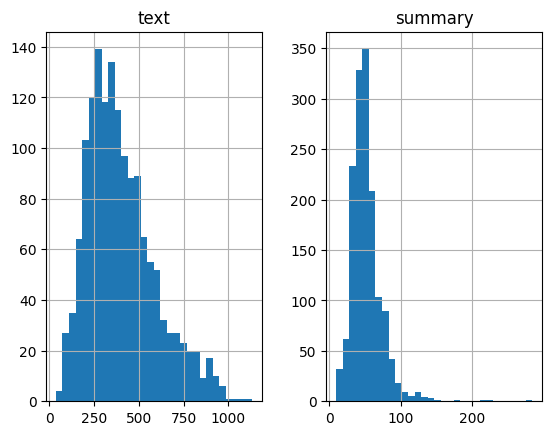

In [ ]:

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
print(max(text_word_count),max(summary_word_count))

1131 284


In [ ]:
cmax_len_text=240
max_len_summary=40

In [ ]:
from sklearn.model_selection import train_test_split
input_texts,x_val,target_texts,y_val=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.2,random_state=0,shuffle=True)

In [ ]:
articles=list(input_texts)
test_articles=list(x_val)
summaries=list(target_texts)
test_summaries=list(y_val)

In [ ]:
len(articles),len(summaries)

(1200, 1200)

In [ ]:
from datasets import DatasetDict, Dataset

# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict({'dialogue': articles, 'summary': summaries}),
    'validation': Dataset.from_dict({'dialogue': test_articles, 'summary': test_summaries})
})

# Print dataset info
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 1200
    })
    validation: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 300
    })
})


In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
len(dataset['train'])

1200

In [ ]:
def format_instruction(dialogue: str, summary: str):
	return f"""### Instruction:
Summarize the following conversation.

### Input:
{dialogue.strip()}

### Summary:
{summary}
""".strip()


In [ ]:
def generate_instruction_dataset(data_point):

    return {
        "dialogue": data_point["dialogue"],
        "summary": data_point["summary"],
        "text": format_instruction(data_point["dialogue"],data_point["summary"])
    }

In [ ]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_instruction_dataset)
    )

In [ ]:
sample_dataset = dataset.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/1200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
type(sample_dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
sample_dataset["train"] = process_dataset(sample_dataset["train"])
sample_dataset["test"] = process_dataset(sample_dataset["validation"])
sample_dataset["validation"] = process_dataset(sample_dataset["validation"])

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
## APPLYING PREPROCESSING ON WHOLE DATASET
dataset["train"] = process_dataset(dataset["train"])
dataset["validation"] = process_dataset(dataset["validation"])

train_data = dataset['train'].shuffle(seed=42).select([i for i in range(160)])
# Select 10 rows for the test
test_data = dataset['train'].shuffle(seed=42).select([i for i in range(10)])
validation_data = dataset['validation'].shuffle(seed=42).select([i for i in range(40)])

train_data,test_data,validation_data

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

(Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 160
 }),
 Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 10
 }),
 Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 40
 }))

In [ ]:
train_data['dialogue'][0]

"prankster dad may win award cruelest joke tricked wife thinking threw toddler son balcony. roman atwood set cameras enlisted help two sons elaborate attempt frighten unassuming wife fool thinking would accidentally killed toddler son. stunt, posted youtube november already almost million views, begins atwood playing son, dressed spider man costume covering face, top floor los angeles, california home. like day loving mother returns home los angeles finds husband roman atwood playing toddler son dressed spider man costume . switcheroo roman atwood enlists help elder son leads toddler room hands dad small dummy dressed costume son . launch roman atwood pretends throw son balcony wife lets shriek rushes towards believes fallen son . atwood son greeted lovingly boy’s mother, sent downstairs 'to grab water' prepare prank behind back. atwood enlists help older son leads younger brother room substitutes toddler dummy, atwood tosses railing. wife runs downstairs screams paralyzing fear sees b

In [ ]:
sample_dataset["train"]["text"][0]

"### Instruction:\nSummarize the following conversation.\n\n### Input:\n. harriet arkell . published . est, march . | . updated . est, march . power cut left three fuel storage pools japan tsunami damaged nuclear plant without fresh cooling water nearly hours, raising concerns fragility tsunami ravaged nuclear plant. fukushima dai ichi nuclear plant operator said temperatures pools within safe limits would remain four days, incident highlighted problems caused continued use makeshift equipment damaged plant. spokesman tokyo electric power company said reactors affected power outage said staff preparing back system case repairs fix problem. new aerial photo fukushima plant shows reactor buildings damaged tsunami . masayuki ono said 'if worst comes worst, backup water injection system.' command centre plant suffered brief power failure pm local time yesterday, knocking cooling facilities four fuel ponds. electricity quickly restored command centre, tuesday afternoon cooling system restor

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id =  "NousResearch/Llama-2-7b-hf" #this is not a chat model but a base model it wont have understanding of promts and commands, it just generate
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


## ZERO-SHOT INFERENCE WITH LLAMA-2 7B
we are using base model to write summary

In [ ]:
index = 0

dialogue = articles[index]
summary = summaries[index]

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=100,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
lori hyde hunting unique vacation experience curiosity piqued pretty joe rock, tiny speck land waters marathon florida keys enough room two bedroom home clusters mangroves. husband spent week petite island february, relaxing enjoying company, one else around resident birds. looking rental would private came searching around like, well cannot get much private that, said hyde, , stay home mom lives woodbridge, virginia. exclusive sort thing. ordinary people something cool. indeed, idea renting private island usually conjures images multimillionaires spending fortune jet tropical paradise caribbean south pacific. lot money shell out, possibilities endless. big budget give options luxurious accommodations, rich rent island vacation. sometimes take little hundred dollars week, sense adventure willingness look locations closer ho

# Training Setup

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(

    # r stands number of rank decomposition matrix (higher rank leads better results but high computations)
    r=16,

    lora_alpha=64, # scaling factor, determines the extend t0 which the model is adapted towards new training data  (lower value gives more weightage to the original data or biased towards baise model)

    # target_modules=["query_key_value"],

    #specific to Llama models. here we can determines which specific weights and matrices are to be trained (most basic are to train qeury and value vectors)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #here o_proj is for output

    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 16777216 || all params: 3517190144 || trainable%: 0.477006226934315


# Training

In [ ]:
OUTPUT_DIR = "llama2-docsum-adapter"

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit", #a special type of adam optimizer used for training llm models
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=validation_data,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
4,3.031300,3.208272
8,3.119900,3.122039
12,2.938100,3.065866
16,2.747400,3.040343
20,2.876900,3.035052


TrainOutput(global_step=20, training_loss=3.0662811994552612, metrics={'train_runtime': 1043.1988, 'train_samples_per_second': 0.307, 'train_steps_per_second': 0.019, 'total_flos': 4762967959240704.0, 'train_loss': 3.0662811994552612, 'epoch': 2.0})

In [ ]:
peft_model_path="./peft-dialogue-summary"

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary/tokenizer_config.json',
 './peft-dialogue-summary/special_tokens_map.json',
 './peft-dialogue-summary/tokenizer.model',
 './peft-dialogue-summary/added_tokens.json',
 './peft-dialogue-summary/tokenizer.json')

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

peft_model_dir = "peft-dialogue-summary"

# load base LLM model and tokenizer
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_dir)

In [ ]:
index = 0

dialogue = articles[index]
summary = summaries[index]

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
# output = tokenizer.decode(
#     trained_model.generate(
#         inputs_ids,
#         max_new_tokens=100,
#     )[0],
#     skip_special_tokens=True
# )
outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=100, )
output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
lori hyde hunting unique vacation experience curiosity piqued pretty joe rock, tiny speck land waters marathon florida keys enough room two bedroom home clusters mangroves. husband spent week petite island february, relaxing enjoying company, one else around resident birds. looking rental would private came searching around like, well cannot get much private that, said hyde, , stay home mom lives woodbridge, virginia. exclusive sort thing. ordinary people something cool. indeed, idea renting private island usually conjures images multimillionaires spending fortune jet tropical paradise caribbean south pacific. lot money shell out, possibilities endless. big budget give options luxurious accommodations, rich rent island vacation. sometimes take little hundred dollars week, sense adventure willingness look locations closer ho

# Merge Trained LoRA Adapter With BASE MODEL and Push Model to Hub

---



Not needed

In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
# Merge LoRA and base model
merged_model = trained_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
# merged_model.push_to_hub("user/repo")
# tokenizer.push_to_hub("user/repo")